# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
!ls -lh data/*

-rw-rw-r-- 1 dima806 dima806  78K Nov  7 10:53 'data/DIAS Attributes - Values 2017.xlsx'
-rw-rw-r-- 1 dima806 dima806  33K Nov  7 10:53 'data/DIAS Information Levels - Attributes 2017.xlsx'
-rw-rw-r-- 1 dima806 dima806 651M Nov  7 11:24  data/Udacity_AZDIAS_052018.csv
-rw-rw-r-- 1 dima806 dima806 138M Nov  7 11:25  data/Udacity_CUSTOMERS_052018.csv
-rw-rw-r-- 1 dima806 dima806  31M Nov  7 11:28  data/Udacity_MAILOUT_052018_TEST.csv
-rw-rw-r-- 1 dima806 dima806  31M Nov  7 11:28  data/Udacity_MAILOUT_052018_TRAIN.csv


In [2]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import time
import datetime
import gc
from tqdm import tqdm
from collections import Counter
from sklearn.preprocessing import MinMaxScaler
from sklearn.cross_validation import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import make_scorer, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier, LGBMRegressor

#suppress warnings
import warnings
warnings.filterwarnings("ignore")

# magic word for producing visualizations in notebook
%matplotlib inline

# Change pandas viewing options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

/home/dima806/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [3]:
%%time
customers = pd.read_csv('data/Udacity_CUSTOMERS_052018.csv', sep=';')
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Columns: 369 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(94), object(8)
memory usage: 539.5+ MB
CPU times: user 4.37 s, sys: 533 ms, total: 4.9 s
Wall time: 4.91 s


In [4]:
%%time
azdias = pd.read_csv('data/Udacity_AZDIAS_052018.csv', sep=';')
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 2.4+ GB
CPU times: user 22.5 s, sys: 11.1 s, total: 33.6 s
Wall time: 55.4 s


### 0.1. Preprocessing of categorical features:

In [5]:
azdias.select_dtypes(include=['object']).nunique().sort_values()

OST_WEST_KZ                    2
CAMEO_DEUG_2015               19
D19_LETZTER_KAUF_BRANCHE      35
CAMEO_INTL_2015               43
CAMEO_DEU_2015                45
EINGEFUEGT_AM               5162
dtype: int64

In [6]:
azdias.select_dtypes(include=['object']).head(10)

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ
0,NaN,NaN,NaN,NaN,NaN,NaN
1,8A,8,51,NaN,1992-02-10 00:00:00,W
2,4C,4,24,D19_UNBEKANNT,1992-02-12 00:00:00,W
3,2A,2,12,D19_UNBEKANNT,1997-04-21 00:00:00,W
4,6B,6,43,D19_SCHUHE,1992-02-12 00:00:00,W
5,8C,8,54,D19_ENERGIE,1992-02-12 00:00:00,W
6,4A,4,22,D19_UNBEKANNT,1992-02-12 00:00:00,W
7,2D,2,14,D19_UNBEKANNT,1992-02-10 00:00:00,W
8,1A,1,13,NaN,1992-02-10 00:00:00,W
9,1E,1,15,D19_KOSMETIK,1992-02-10 00:00:00,W


According to DIAS Attributes, column `OST_WEST_KZ` is the flag indicating the former GDR/FRG.

Next, according to DIAS Information Levels, columns `CAMEO_DEUG_2015`, `CAMEO_INTL_2015` and `CAMEO_DEU_2015` represent "New German CAMEO Typology established together with Call Credit in late 2015". Look into them for more details.

First, by using [order-of-appearence label encoding](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.factorize.html) we see that features `CAMEO_DEU_2015` and `CAMEO_INTL_2015` are **not** identical, so we need to keep them both:

In [7]:
np.all(pd.factorize(azdias.CAMEO_DEU_2015.head(1000), sort=False)[0] == 
       pd.factorize(azdias.CAMEO_INTL_2015.head(1000), sort=False)[0])

False

Also, the first letter of `CAMEO_DEU_2015` feature does not always correspond to `CAMEO_DEUG_2015` feature, so we should keep them both:

In [8]:
def get_first_letter(x):
    '''
    Strips first letter from a string.
    If the string is NaN (so the functions returns TypeError), returns NaN
    
    Args:
        x (string) -  value to strip (probably np.nan)
    Returns:
        x (string) - first letter from a string (if it exists) or NaN (elsewhere)
    '''
    try:
        return x[0]
    except TypeError:
        return x
    
np.all(pd.factorize(azdias.CAMEO_DEU_2015.head(10000).map(get_first_letter), sort=False)[0] == 
       pd.factorize(azdias.CAMEO_DEUG_2015.head(10000), sort=False)[0])

False

Then, feature `D19_LETZTER_KAUF_BRANCHE` can also be directly label-encoded.

Finally, feature `EINGEFUEGT_AM` can be transformed to datestamp:

In [9]:
azdias.EINGEFUEGT_AM.head()

0                    NaN
1    1992-02-10 00:00:00
2    1992-02-12 00:00:00
3    1997-04-21 00:00:00
4    1992-02-12 00:00:00
Name: EINGEFUEGT_AM, dtype: object

In [10]:
def timestring_toordinal(s):
    '''
    Converts string in format "YYYY-mm-dd HH:MM:SS" to ordinal days
    (where January 1 of year 0001 has ordinal 1).
    If s is np.nan, returns s instead.
    
    Args:
        s (string) - date string in format "YYYY-mm-dd HH:MM:SS"
    
    Returns:
        day (int) - ordinal day
    '''
    try:
        d = datetime.datetime.strptime(s, "%Y-%m-%d %H:%M:%S")
        day = datetime.date.toordinal(d)
        return day
    except TypeError:
        return s

In [11]:
for df in [azdias, customers]:
    df['EINGEFUEGT_AM'] = df.EINGEFUEGT_AM.apply(timestring_toordinal)

Let us also transform the rest of categorical columns:

In [12]:
for col in ['CAMEO_DEU_2015', 
            'CAMEO_DEUG_2015', 
            'CAMEO_INTL_2015', 
            'D19_LETZTER_KAUF_BRANCHE', 
            'OST_WEST_KZ']:
    if set(azdias[col].unique()) == set(customers[col].unique()):
        print('Transforming feature {} ...'.format(col))
        for df in [azdias, customers]:
            labels, uniques = pd.factorize(df[col], sort=True)
            df_unique = pd.DataFrame(uniques, 
                                     index = range(1, len(uniques)+1), 
                                     columns=[col])
            df_unique.to_csv('feature_index_'+col+'.csv')
            df[col] = labels
            df[col] = df[col].apply(lambda x: x if x >= 0 else np.nan)

Transforming feature CAMEO_DEU_2015 ...
Transforming feature CAMEO_DEUG_2015 ...
Transforming feature CAMEO_INTL_2015 ...
Transforming feature D19_LETZTER_KAUF_BRANCHE ...
Transforming feature OST_WEST_KZ ...


In [13]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(273), int64(93)
memory usage: 2.4 GB


In [14]:
! ls -lotr *csv

-rw-r--r-- 1 dima806   1020 Dec  3 14:34 good_customer_dict_2.5.csv
-rw-r--r-- 1 dima806    554 Dec  3 14:47 good_customer_dict_3.0.csv
-rw-r--r-- 1 dima806    221 Dec  3 15:01 good_customer_dict_4.0.csv
-rw-r--r-- 1 dima806    121 Dec  3 15:15 good_customer_dict_5.0.csv
-rw-r--r-- 1 dima806 774181 Dec  5 13:33 response0.csv
-rw-r--r-- 1 dima806 769741 Dec 10 15:05 response.csv
-rw-r--r-- 1 dima806    277 Dec 10 16:03 feature_index_CAMEO_DEU_2015.csv
-rw-r--r-- 1 dima806    121 Dec 10 16:03 feature_index_CAMEO_DEUG_2015.csv
-rw-r--r-- 1 dima806    308 Dec 10 16:03 feature_index_CAMEO_INTL_2015.csv
-rw-r--r-- 1 dima806    657 Dec 10 16:03 feature_index_D19_LETZTER_KAUF_BRANCHE.csv
-rw-r--r-- 1 dima806     21 Dec 10 16:03 feature_index_OST_WEST_KZ.csv


In [15]:
Counter(azdias.KBA05_MOD8.dropna())

Counter({0.0: 221889, 1.0: 217315, 2.0: 216657, 3.0: 87250, 9.0: 14786})

### 0.2. Preprocessing of numerical features

Start from identification of NaN values.
DIAS Attributes Excel table contains information about each column:

In [16]:
attributes_all = pd.read_excel('data/DIAS Attributes - Values 2017.xlsx', index=['Attribute'])

In [17]:
attributes_all.drop(['Unnamed: 0', 'Description'], axis=1, inplace=True)

In [18]:
attributes_all.Attribute.fillna(method='ffill', inplace=True)

In [19]:
unknown_strings = [i for i in set(attributes_all.Meaning.dropna().values) if 'unknown' in i]
unknown_strings

['unknown', 'unknown / no main age detectable']

In [20]:
attributes = attributes_all[attributes_all.Meaning.isin(unknown_strings)]

In [21]:
attributes.index = attributes.Attribute

In [22]:
attributes.drop(['Attribute', 'Meaning'], axis=1, inplace=True)

In [23]:
attributes.head()

,Value
Attribute,
AGER_TYP,-1
ALTERSKATEGORIE_GROB,"-1, 0"
ALTER_HH,0
ANREDE_KZ,"-1, 0"
BALLRAUM,-1


In [24]:
def split_values(x):
    '''
    Splits Value keyword in attributes.
    If value is integer, returns list with the value element
    
    Args:
        x (string or int) - attributes.Value
    
    Returns:
        split_val
    '''
    try:
        split_val = [int(i) for i in x.split(', ')]
    except AttributeError:
        split_val = [int(x)]
    return split_val

In [25]:
attributes['Value'] = attributes.Value.apply(split_values)

In [26]:
attributes_dict = attributes.to_dict()['Value']

In [27]:
for df in [azdias, customers]:
    for col in attributes_dict.keys():
        if col in df.columns:
            for val in attributes_dict[col]:
                if val in df[col].dropna().unique():
                    df[col] = df[col].replace({val: np.nan})

Finally, look on yearly columns (that contain 'JAHR' in the name):

In [28]:
for col in azdias.columns:
    if 'JAHR' in col:
        print(col, azdias[col].min(), azdias[col].max())

EINGEZOGENAM_HH_JAHR 1900.0 2018.0
GEBURTSJAHR 0 2017
MIN_GEBAEUDEJAHR 1985.0 2016.0
PRAEGENDE_JUGENDJAHRE 1.0 15.0


Column `GEBURTSJAHR` is suspicious as it contains years from 0 to 2017. Look on it closer:

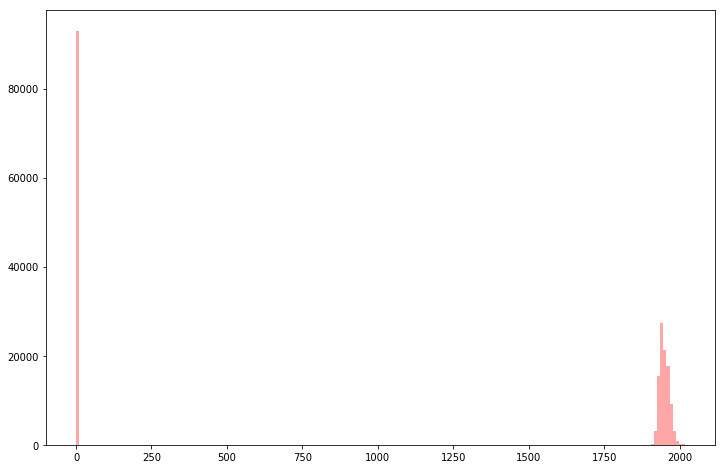

In [29]:
plt.rcParams["figure.figsize"] = (12.0, 8.0)
plt.hist(customers.GEBURTSJAHR.values, bins=200, color='r', alpha=0.35);
plt.show()

Clearly, there is an unphysical peak at 0 that should be converted to NaNs:

In [30]:
Counter(customers.GEBURTSJAHR.dropna().values).most_common(10)

[(0, 93024),
 (1941, 3535),
 (1940, 3085),
 (1939, 3071),
 (1943, 2875),
 (1942, 2802),
 (1938, 2775),
 (1944, 2625),
 (1937, 2603),
 (1936, 2443)]

In [31]:
for df in [azdias, customers]:
    df['GEBURTSJAHR'] = df['GEBURTSJAHR'].replace({0: np.nan})

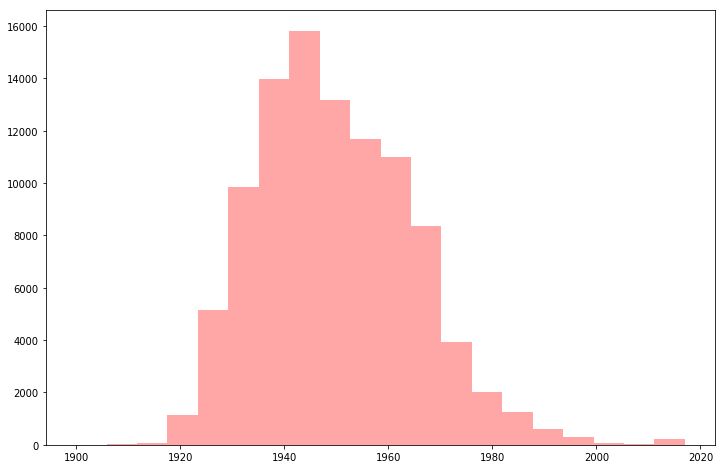

In [32]:
plt.rcParams["figure.figsize"] = (12.0, 8.0)
plt.hist(customers.GEBURTSJAHR.dropna().values, bins=20, color='r', alpha=0.35);
plt.show()

In [33]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(280), int64(86)
memory usage: 2.4 GB


In [34]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Columns: 369 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(280), int64(87), object(2)
memory usage: 539.5+ MB


## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### 1.1. Visual inspection.
Build histograms and compare distributions by eye.
To simplify comparison, a random subset of `azdias` is used, where the number of customers is the same as in `customers` dataset:

In [35]:
np.random.seed(83) # fix random seed
N = customers.shape[0] # the same as for customers
azdias_sel = azdias.sample(N)

In [36]:
azdias_sel.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 191652 entries, 237112 to 253793
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(280), int64(86)
memory usage: 536.6 MB


In [37]:
extra_cols = list(set(customers.columns)-set(azdias_sel.columns))

In [38]:
customers[extra_cols].head()

,ONLINE_PURCHASE,PRODUCT_GROUP,CUSTOMER_GROUP
0,0,COSMETIC_AND_FOOD,MULTI_BUYER
1,0,FOOD,SINGLE_BUYER
2,0,COSMETIC_AND_FOOD,MULTI_BUYER
3,0,COSMETIC,MULTI_BUYER
4,0,FOOD,MULTI_BUYER


There are also 5 features (`['TITEL_KZ', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4']`) that have more than `90%` of missing values in both `azdias` and `customers` datasets:

In [39]:
dd = azdias.isnull().mean(axis=0).sort_values(ascending=False).head(20)
for col in dd.index:
    print(col, dd[col], customers.isnull().mean(axis=0)[col])

ALTER_KIND4 0.9986479223447383 0.9987686014234133
TITEL_KZ 0.9975763587258379 0.987936468181913
ALTER_KIND3 0.9930769135826019 0.9933473170120845
ALTER_KIND2 0.9669004657655059 0.9733892680483376
ALTER_KIND1 0.9090483729624863 0.9386074760503412
AGER_TYP 0.7601964047076988 0.48059503683760146
EXTSEL992 0.7339963937115486 0.44498883392816146
KK_KUNDENTYP 0.6559674873011295 0.5840638240143594
KBA05_BAUMAX 0.5346866826522265 0.5715306910441843
GEBURTSJAHR 0.4402028228688507 0.48537975079832196
ALTER_HH 0.34813699407890975 0.35870744891783024
ALTERSKATEGORIE_FEIN 0.29504129727643313 0.27050069918393754
D19_BANKEN_ONLINE_QUOTE_12 0.2884952217239046 0.24887295723498842
D19_VERSAND_ONLINE_QUOTE_12 0.2884952217239046 0.24887295723498842
D19_TELKO_ONLINE_QUOTE_12 0.2884952217239046 0.24887295723498842
D19_SOZIALES 0.2884952217239046 0.24887295723498842
D19_GESAMT_ONLINE_QUOTE_12 0.2884952217239046 0.24887295723498842
D19_KONSUMTYP 0.2884952217239046 0.24887295723498842
D19_LOTTO 0.2884952217239

Because these 5 features have too few non-NaN values, they are dropped from further analysis:

In [40]:
drop_nan_cols = ['TITEL_KZ', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4']
for df in [azdias_sel, azdias, customers]:
    df = df.drop(drop_nan_cols, axis=1, inplace=True)

In [41]:
def plot_col(customers, azdias, col, customers_legend='customers', azdias_legend='general'):
    '''
    Plots historgams of customer and azdias datasets for the given column
    
    Args:
        customers (pandas dataframe) - dataframe of customers
        azdias (pandas dataframe) - dataframe of general population 
        (preferrably normalized to have the same number of instances as customers dataset)
        col (string) - name of column to plot
        customers_legend (string) - name to legend the customers in plots
        azdias_legend (string) - name to legend the general population in plots
    
    Returns:
        None
    '''

    plt.rcParams["figure.figsize"] = (14.0, 2.0)
    fig = plt.figure()
    plt.switch_backend('agg') # important to plot xlabel and ylabel
    
    # Left plot - compare customers_pos and azdias subsample
    try:
        ax0 = fig.add_subplot(1,4,1)
        customers_diff = int(customers[col[0]].max()-customers[col[0]].min())
        azdias_diff = int(azdias[col[0]].max()-azdias[col[0]].min())
        ax0.hist(customers[col[0]].dropna().values-0.5, 
                 color='r', alpha=0.35, 
                 bins=min([customers_diff, 50]))
        ax0.hist(azdias[col[0]].dropna().values-0.5, 
                 color='b', alpha=0.35, 
                 bins=min([azdias_diff, 50]))
        ax0.legend([customers_legend, azdias_legend])
        ax0.set_title(col[0], size='10')
    except IndexError:
        pass
    except ValueError:
        pass
    
    try:
        ax1 = fig.add_subplot(1,4,2)
        customers_diff = int(customers[col[1]].max()-customers[col[1]].min())
        azdias_diff = int(azdias[col[1]].max()-azdias[col[1]].min())
        ax1.hist(customers[col[1]].dropna().values-0.5, 
                 color='r', alpha=0.35, 
                 bins=min([customers_diff, 50]))
        ax1.hist(azdias[col[1]].dropna().values-0.5, 
                 color='b', alpha=0.35, 
                 bins=min([azdias_diff, 50]))
        ax1.legend([customers_legend, azdias_legend])
        ax1.set_title(col[1], size='10')
    except IndexError:
        pass
    except ValueError:
        pass
    
    try:
        ax2 = fig.add_subplot(1,4,3)
        customers_diff = int(customers[col[2]].max()-customers[col[2]].min())
        azdias_diff = int(azdias[col[2]].max()-azdias[col[2]].min())
        ax2.hist(customers[col[2]].dropna().values-0.5, 
                 color='r', alpha=0.35, 
                 bins=min([customers_diff, 50]))
        ax2.hist(azdias[col[2]].dropna().values-0.5, 
                 color='b', alpha=0.35, 
                 bins=min([azdias_diff, 50]))
        ax2.legend([customers_legend, azdias_legend])
        ax2.set_title(col[2], size='10')
    except IndexError:
        pass
    except ValueError:
        pass

    try:
        ax3 = fig.add_subplot(1,4,4)
        customers_diff = int(customers[col[3]].max()-customers[col[3]].min())
        azdias_diff = int(azdias[col[3]].max()-azdias[col[3]].min())
        ax3.hist(customers[col[3]].dropna().values-0.5, 
                 color='r', alpha=0.35, 
                 bins=min([customers_diff, 50]))
        ax3.hist(azdias[col[3]].dropna().values-0.5, 
                 color='b', alpha=0.35, 
                 bins=min([azdias_diff, 50]))
        ax3.legend([customers_legend, azdias_legend])
        ax3.set_title(col[3], size='10')
    except IndexError:
        pass
    except ValueError:
        pass
    plt.show()
    
cols = list(azdias_sel.select_dtypes(exclude=['object']).columns)
cols.remove('LNR')
for i, _ in enumerate(cols):
    if i % 4 == 0:
        plot_col(customers, azdias_sel, cols[i:i+4])

The largest distinction between distributions of `customers` and `azdias_sel` datasets is in the column `D19_SOZIALES`:

In [42]:
plot_col(customers, azdias_sel, ['D19_SOZIALES'])

Because description of the column `D19_SOZIALES` is missing in accompanying documents, it is important to investigate what is the difference between its values `0` and `1` in terms of other columns:

In [43]:
azdias_sel_1 = azdias[azdias.D19_SOZIALES == 1]
azdias_sel_0 = azdias[azdias.D19_SOZIALES == 0].sample(azdias_sel_1.shape[0])
# for i, _ in enumerate(cols):
#     if i % 4 == 0:
#         plot_col(azdias_sel_1, azdias_sel_0, cols[i:i+4], 'D19_SOZ = 1', 'D19_SOZ = 0')

Look what columns maximally (anti)correlate with `D19_SOZIALES`:

In [44]:
np.random.seed(83)
sociales_top_corr = np.abs(azdias.sample(10000).corr()['D19_SOZIALES'].dropna()).sort_values(ascending=False).head(20)

In [45]:
sociales_top_corr = sociales_top_corr.reset_index()
sociales_top_corr.columns = ['colname', 'abscorr with D19_SOZIALES']
sociales_top_corr

,colname,abscorr with D19_SOZIALES
0,D19_SOZIALES,1.000000
1,VK_ZG11,0.304921
2,VK_DISTANZ,0.261191
3,EINGEZOGENAM_HH_JAHR,0.250573
4,D19_SAMMELARTIKEL,0.224254
5,GEBURTSJAHR,0.214010
6,FINANZ_SPARER,0.207920
7,FINANZ_MINIMALIST,0.204257
8,CJT_TYP_2,0.201304
9,HH_EINKOMMEN_SCORE,0.196977


In [46]:
sociales_top_corr['is_attribute'] = sociales_top_corr['colname'].apply(lambda x: x in attributes_all.Attribute.unique())
sociales_top_corr.head(12)

,colname,abscorr with D19_SOZIALES,is_attribute
0,D19_SOZIALES,1.000000,False
1,VK_ZG11,0.304921,False
2,VK_DISTANZ,0.261191,False
3,EINGEZOGENAM_HH_JAHR,0.250573,False
4,D19_SAMMELARTIKEL,0.224254,False
5,GEBURTSJAHR,0.214010,True
6,FINANZ_SPARER,0.207920,True
7,FINANZ_MINIMALIST,0.204257,True
8,CJT_TYP_2,0.201304,False
9,HH_EINKOMMEN_SCORE,0.196977,True


As we see, the largest (anti)correlation between `D19_SOZIALES` and the columns with known description is with columns `FINANZ_SPARER` and `FINANZ_MINIMALIST`. Look on distribution in more details:

In [47]:
plot_col(azdias_sel_1, azdias_sel_0, 
         ['GEBURTSJAHR', 'FINANZ_SPARER', 'FINANZ_MINIMALIST', 'HH_EINKOMMEN_SCORE'], 
         'D19_SOZ = 1', 'D19_SOZ = 0')

In [48]:
attributes_all[attributes_all.Attribute.isin(['GEBURTSJAHR', 
                                              'FINANZ_SPARER', 
                                              'FINANZ_MINIMALIST', 
                                              'HH_EINKOMMEN_SCORE'])]

,Attribute,Value,Meaning
673,FINANZ_MINIMALIST,-1,unknown
674,FINANZ_MINIMALIST,1,very high
675,FINANZ_MINIMALIST,2,high
676,FINANZ_MINIMALIST,3,average
677,FINANZ_MINIMALIST,4,low
678,FINANZ_MINIMALIST,5,very low
679,FINANZ_SPARER,-1,unknown
680,FINANZ_SPARER,1,very high
681,FINANZ_SPARER,2,high
682,FINANZ_SPARER,3,average


As we see, people with `D19_SOZIALES == 1` (close to the customer target group) are **older in average** (`GEBURTSJAHR` means year of birth), have **more savings** (= less `FINANZ_SPARER`) and **higher estimated household income** (= less `HH_EINKOMMEN_SCORE`).

Then, look onto a 2D plot made by `['D19_SOZIALES', 'FINANZ_SPARER']` columns:

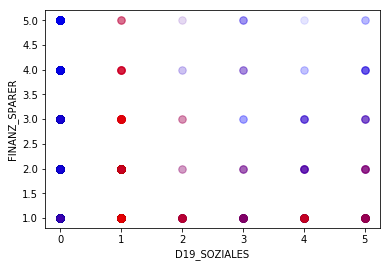

In [49]:
distinguished_cols = ['D19_SOZIALES', 'FINANZ_SPARER'] #['GEBURTSJAHR', 'ALTER_HH', 'VK_ZG11', 'D19_KONSUMTYP', 'ALTERSKATEGORIE_FEIN']
plt.rcParams["figure.figsize"] = (6.0, 4.0)
n_samples=2000
sample_adzias = azdias[distinguished_cols].dropna().sample(n_samples).values
sample_customers = customers[distinguished_cols].dropna().sample(n_samples).values
for i in range(n_samples):
    plt.plot(sample_adzias[i][0], sample_adzias[i][1], 'b.', alpha=0.05, markersize=15)
    plt.plot(sample_customers[i][0], sample_customers[i][1], 'r.', alpha=0.05, markersize=15)
plt.xlabel(distinguished_cols[0])
plt.ylabel(distinguished_cols[1])
plt.show()

### 1.2. Quantitative analysis.
Here I describe criteria for selecting parts of general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In addition to visual inspection, it is important to find out the special parameters values which customers possess much more (e.g. 2 times more) often than general population.

In [50]:
def get_good_customers(customers, azdias, threshold=5.0):
    '''
    Extracts dictionary which items are columns for which the number of customers
    is more than by a threshold times larger 
    (given 5sigma extra margin to suppress customers fluctuations)
    than the corresponding number of general population
    (normalized by total number of counts).

    Then, converts dictionary to pandas dataframe.
    
    Finally, saves the dataframe as CSV file (in format 'good_customer_dict_'+threshold+'.csv')
    and returns the dataframe.  
    
    Args:
        customer (pandas dataframe) - dataframe with customers
        azdias (pandas dataframe) - dataframe with general population
        threshold (float64) - the minimal factor where the number of customers in a given field should 
        exceed the corresponding number of general population (normalized by total number of counts)
    
    Returns:
        good_customer_df (pandas dataframe) - dataframe with values for each column where number of customers 
        exceeds more than threshold times the number of general population (taken from azdias)
        Also, saves the d
    '''

    good_customer_dict = dict()

    for col in tqdm(azdias.columns):
        if col != 'LNR':
            azdias_total_cts = azdias[col].dropna().shape[0]
            customers_total_cts = customers[col].dropna().shape[0]
            good_customer_dict[col] = []
            val_list = customers[col].dropna().unique()
            for val in val_list:
                customers_count = customers[customers[col] == val].shape[0]
                azdias_count = azdias[azdias[col] == val].shape[0]
                # below the normalized quantities are compared given ~5sigma extra margin:
                if customers_count * azdias_total_cts > 5*np.sqrt(customers_count) * azdias_total_cts + threshold * azdias_count * customers_total_cts:
                    good_customer_dict[col].append(val)
            good_customer_dict[col] = sorted(good_customer_dict[col])
            if good_customer_dict[col] == []:
                good_customer_dict.pop(col)
    good_customer_df = pd.DataFrame(index=good_customer_dict.keys(), columns=['value'])

    # save good_customer_dict as pandas dataframe
    for i in good_customer_dict.keys():
        good_customer_df.loc[i, 'value'] = good_customer_dict[i]
    good_customer_df.to_csv('good_customer_dict_'+str(threshold)+'.csv')
    
    return good_customer_df

Runs about 50 minitues, so skipping this step

In [51]:
# for threshold in [2.5, 3.0, 4.0, 5.0]:
#     get_good_customers(customers, azdias, threshold)

In [52]:
! ls -lotr good_customer_dict_*csv

-rw-r--r-- 1 dima806 1020 Dec  3 14:34 good_customer_dict_2.5.csv
-rw-r--r-- 1 dima806  554 Dec  3 14:47 good_customer_dict_3.0.csv
-rw-r--r-- 1 dima806  221 Dec  3 15:01 good_customer_dict_4.0.csv
-rw-r--r-- 1 dima806  121 Dec  3 15:15 good_customer_dict_5.0.csv


In [53]:
df = pd.read_csv('good_customer_dict_5.0.csv')
df.index = df['Unnamed: 0']
df.drop('Unnamed: 0', axis=1, inplace=True)
df['val'] = df.value.apply(lambda x: [float(i) for i in x[1:-1].split(', ')])
df['val'].loc['D19_SOZIALES']
df.to_dict()['val']

{'ANZ_STATISTISCHE_HAUSHALTE': [0.0],
 'D19_SOZIALES': [1.0],
 'LP_LEBENSPHASE_FEIN': [40.0],
 'PRAEGENDE_JUGENDJAHRE': [2.0, 4.0]}

To understand the effectiveness of this selection, calculate the fraction of original instances in `customers` and `azdias` datasets that will be left after selection for all of the criteria found in `good_customer_dict`:

In [54]:
def show_effectiveness(threshold = '5.0'):
    '''
    Creates combined selection criterion (using logical OR) and calculates the fraction of customers
    and general population filtered with the obtained criterion
    
    Args:
        good_customer_dict (dict) - dictionary with selection criteria

    Returns:
        customers_ratio (float64) - fraction of filtered customers
        azdias_ratio (float64) - fraction of filtered general population
    '''

    customers_filtered_index = []
    azdias_filtered_index = []
    df = pd.read_csv('good_customer_dict_'+threshold+'.csv')
    df.index = df['Unnamed: 0']
    df.drop('Unnamed: 0', axis=1, inplace=True)
    df['val'] = df.value.apply(lambda x: [float(i) for i in x[1:-1].split(', ')])
    good_customer_dict = df.to_dict()['val']
    for key, val in good_customer_dict.items():
        customers_filtered_index += list(customers[customers[key].isin(val)].index)
        customers_filtered_index = list(set(customers_filtered_index))
        azdias_filtered_index += list(azdias[azdias[key].isin(val)].index)
        azdias_filtered_index = list(set(azdias_filtered_index))
        print(key, val, len(customers[customers[key].isin(val)].index), len(customers_filtered_index))

    customers_ratio = len(customers_filtered_index)/customers.shape[0]
    azdias_ratio = len(azdias_filtered_index)/azdias.shape[0]
    return customers_ratio, azdias_ratio 

In [55]:
for threshold in ['2.5', '3.0', '4.0', '5.0']:
    print('>'*40)
    print(show_effectiveness(threshold))

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
ALTER_HH [7.0, 8.0, 9.0] 26394 26394
ALTERSKATEGORIE_FEIN [6.0, 7.0, 8.0, 9.0] 41049 43154
ANZ_STATISTISCHE_HAUSHALTE [0.0] 1161 43889
ANZ_TITEL [1.0, 2.0] 2731 45654
CAMEO_DEU_2015 [2.0, 3.0, 4.0] 11423 52703
CAMEO_DEUG_2015 [9.0] 12498 55220
CAMEO_INTL_2015 [24.0] 6845 55220
CJT_TYP_1 [1.0] 55916 79120
D19_BANKEN_OFFLINE_DATUM [5.0] 2959 80252
D19_BILDUNG [1.0, 2.0] 5720 82996
D19_GESAMT_ONLINE_QUOTE_12 [1.0] 627 83115
D19_KONSUMTYP [2.0, 3.0] 81923 113566
D19_KONSUMTYP_MAX [2.0] 91758 122113
D19_LETZTER_KAUF_BRANCHE [23.0, 34.0] 3034 122204
D19_REISEN [2.0] 2078 122221
D19_SAMMELARTIKEL [6.0] 39605 126946
D19_SOZIALES [1.0] 98964 132242
D19_WEIN_FEINKOST [3.0] 2107 132290
EINGEZOGENAM_HH_JAHR [1989.0, 1994.0] 59643 135149
GEBURTSJAHR [1923.0, 1924.0, 1925.0, 1926.0, 1927.0, 1928.0, 1929.0, 1930.0, 1931.0, 1932.0, 1933.0, 1934.0, 1935.0, 1936.0, 1937.0, 1938.0, 1939.0, 1940.0, 1941.0] 32906 135348
HH_EINKOMMEN_SCORE [1.0] 29936 136491
LP_FAMIL

The remaining fractions as function of threshold are presented in Table:

| Threshold | % of `customers` remains | % of `azdias` remains |
|-----------|--------------------------|-----------------------|
| 2.5       |           95.9%          |         55.1%         |
| 3.0       |           69.4%          |         30.6%         |
| 4.0       |           62.6%          |         16.2%         |
| **5.0**   |           **56.7%**      |          **6.4%**     |

By futher increasing the threshold, one can **decrease** the remaining fractions.

`LP_LEBENSPHASE_FEIN` means "lifestage fine", and the value `40.0` means **"top earners at retirement age from mulitperson households"**.

`PRAEGENDE_JUGENDJAHRE` means "dominating movement in the person's youth (avantgarde or mainstream)".
Value `2.0` means **"40ies - reconstruction years (Avantgarde, East and West Germany)"** and value `4.0` means **"50ies - milk bar / Individualisation (Avantgarde, East and West Germany)"**.

The meaning of other columns of our interest (`ANZ_STATISTISCHE_HAUSHALTE` and `D19_SOZIALES`) is **not described** in apparent .xlsx documents (see the study above in order to reveal the origin of `D19_SOZIALES` feature).

** Finally, it is interesting to compare our findings with results of other people. For example, [this study](https://medium.com/@shihaowen/investigating-customer-segmentation-for-arvato-financial-services-52ebcfc8501), by using standard clustering analysis, found two clusters that altogether contain 53.3% of customers (as a sum of clusters 6 and 7 in their Sec. 3.3), slightly smaller than our recommended value (with `threshold = 5.0`). However, these two clusters also contain 18.1% of general population, almost 3 times larger than our best result (6.4%). As a result, our approach have much "finer" separation of customers then the standard clustering methods.**

In [56]:
# Finally, clean memory from the unnecessary dataframes
for df in [azdias, azdias_sel, azdias_sel_0, azdias_sel_1, customers]:
    del df
gc.collect()

262364

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [57]:
mailout_train = pd.read_csv('data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

In [58]:
mailout_train.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

In [59]:
mailout_train.RESPONSE.mean()

0.012383036171500396

In [60]:
mailout_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42962 entries, 0 to 42961
Columns: 367 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(94), object(6)
memory usage: 120.3+ MB


In [61]:
mailout_train_selected = mailout_train[(mailout_train.D19_SOZIALES.isin([1]))|(mailout_train.ANZ_STATISTISCHE_HAUSHALTE.isin([0.0]))|(mailout_train.LP_LEBENSPHASE_FEIN.isin([40.0]))|(mailout_train.PRAEGENDE_JUGENDJAHRE.isin([2.0, 4.0]))]
mailout_train_selected.RESPONSE.mean() 

0.02587874341359301

In [62]:
def min_max_scaling_wo_nans(df):
    '''
    Applies MinMaxScaler(feature_range=(0, 1)) to dataframe df remaining NaNs.
    Finally, NaNs are filled by -1, far enough from positive samples
    
    Args:
        df (pandas dataframe) - initial dataframe (e.g. azdias)
        
    Returns:
        scaled_filledna_df - final MinMaxScaled dataframe with filled NaNs
    '''
    
    for col in df.columns:
        scaler = MinMaxScaler(feature_range=(0, 1))
        null_index = df[col].isnull()
        if sum(null_index) > 0:
            df.loc[np.array(~null_index), col] = scaler.fit_transform(df.loc[np.array(~null_index), col].values.reshape(-1, 1))
    
    scaled_filledna_df = df.fillna(df.mean())
    
    return scaled_filledna_df

In [63]:
def preprocess_df(df, attributes_dict=attributes_dict):
    '''
    Makes preprocessing of dataframe
    
    Args:
        df (pandas dataframe) - initial dataframe
        attributes_dict (dict) - dict of 'unknown' values from DIAS Attributes (to replace them by NaNs)
    Returns:
        processed_df (pandas dataframe) - final dataframe
    '''

    print('>>> Drop columns with many NaNs:')
    drop_nan_cols = ['TITEL_KZ', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4']
    processed_df = df.drop(drop_nan_cols, axis=1)

    print('>>> Transform EINGEFUEST_AM column to ordinal day:')
    processed_df['EINGEFUEGT_AM'] = processed_df.EINGEFUEGT_AM.apply(timestring_toordinal)

    print('>>> Transform other categorical columns:')
    for col in ['CAMEO_DEU_2015', 
                'CAMEO_DEUG_2015', 
                'CAMEO_INTL_2015', 
                'D19_LETZTER_KAUF_BRANCHE', 
                'OST_WEST_KZ']:
        print('Transforming feature {} ...'.format(col))
        labels, uniques = pd.factorize(processed_df[col], sort=True)
        processed_df[col] = labels
        processed_df[col] = processed_df[col].apply(lambda x: x if x >= 0 else np.nan) 

    print('>>> Replace unknown values (as listed in attributes_dict):')
    for col in attributes_dict.keys():
        if col in processed_df.columns:
            for val in attributes_dict[col]:
                if val in processed_df[col].dropna().unique():
                    processed_df[col] = processed_df[col].replace({val: np.nan})

    print('>>> Replace GEBURTSJAHR zero values to NaNs:')
    processed_df['GEBURTSJAHR'] = processed_df['GEBURTSJAHR'].replace({0: np.nan})
    print('>>> Apply MinMaxScaler and fill NaNs to mean:')
    processed_df = min_max_scaling_wo_nans(processed_df)
    print('>>> Drop LNR column:')
    processed_df.drop('LNR', axis=1, inplace=True)
    
    return processed_df

In [64]:
mailout_train_1 = preprocess_df(mailout_train)

>>> Drop columns with many NaNs:
>>> Transform EINGEFUEST_AM column to ordinal day:
>>> Transform other categorical columns:
Transforming feature CAMEO_DEU_2015 ...
Transforming feature CAMEO_DEUG_2015 ...
Transforming feature CAMEO_INTL_2015 ...
Transforming feature D19_LETZTER_KAUF_BRANCHE ...
Transforming feature OST_WEST_KZ ...
>>> Replace unknown values (as listed in attributes_dict):
>>> Replace GEBURTSJAHR zero values to NaNs:
>>> Apply MinMaxScaler and fill NaNs to mean:
>>> Drop LNR column:


In [65]:
mailout_train_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42962 entries, 0 to 42961
Columns: 361 entries, AGER_TYP to ALTERSKATEGORIE_GROB
dtypes: float64(275), int64(86)
memory usage: 118.3 MB


In [66]:
y = mailout_train_1.RESPONSE.values
X = mailout_train_1.drop(['RESPONSE'], axis=1).values
print(X.shape, y.shape)

(42962, 360) (42962,)


In [67]:
mailout_train_1.head(10)

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,K

In [68]:
seed = 83
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=0.2)

In [69]:
# clf = XGBClassifier(max_depth=7, min_child_weight=1, learning_rate=0.1, n_estimators=1500, 
#                          silent=True, objective='binary:logistic', gamma=0, max_delta_step=0,
#                          subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, 
#                          reg_lambda=0, scale_pos_weight=1, seed=83, missing=None)
clf = XGBClassifier(verbose=1) #make_pipeline()

In [70]:
X_train.shape, y_train.shape

((34369, 360), (34369,))

In [71]:
%%time
clf.fit(X_train, y_train, 
             eval_metric='auc', 
             verbose=True, 
             eval_set=[(X_test, y_test)], early_stopping_rounds=50)

[0]	validation_0-auc:0.77251
Will train until validation_0-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.772398
[2]	validation_0-auc:0.772398
[3]	validation_0-auc:0.772398
[4]	validation_0-auc:0.772398
[5]	validation_0-auc:0.772398
[6]	validation_0-auc:0.772398
[7]	validation_0-auc:0.772398
[8]	validation_0-auc:0.772378
[9]	validation_0-auc:0.772292
[10]	validation_0-auc:0.772292
[11]	validation_0-auc:0.772292
[12]	validation_0-auc:0.772292
[13]	validation_0-auc:0.772292
[14]	validation_0-auc:0.772292
[15]	validation_0-auc:0.772292
[16]	validation_0-auc:0.772292
[17]	validation_0-auc:0.772292
[18]	validation_0-auc:0.772274
[19]	validation_0-auc:0.772099
[20]	validation_0-auc:0.772092
[21]	validation_0-auc:0.771922
[22]	validation_0-auc:0.771654
[23]	validation_0-auc:0.769363
[24]	validation_0-auc:0.769311
[25]	validation_0-auc:0.769122
[26]	validation_0-auc:0.768793
[27]	validation_0-auc:0.768297
[28]	validation_0-auc:0.768198
[29]	validation_0-auc:0.768388
[30]	validation_0

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1, verbose=1)

In [72]:
clf.get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'binary:logistic',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': True,
 'subsample': 1,
 'verbose': 1}

In [73]:
clf = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.8,
       colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=8, min_child_weight=50, missing=None, n_estimators=50,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.6, verbose=1)

Skip RandomizedSearchCV step as it currently runs for approx. 13 hours:

In [74]:
# parameters = {
#     'max_depth' : [5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
#     'subsample' : [0.2, 0.4, 0.6, 0.8, 1.0],
#     'colsample_bytree': [0.2, 0.4, 0.6, 0.8, 1.0],
#     'colsample_bylevel': [0.2, 0.4, 0.6, 0.8, 1.0],
#     'min_child_weight': [0, 1, 2, 5, 10, 20, 50, 100, 200, 500],
#     'learning_rate': [0.001, 0.003, 0.01, 0.03, 0.1, 0.3],
#     'n_estimators' : [50, 100, 200, 500, 1000],
# }


# n_iter = 500 # number of random picks (of 500 000 possibilities)

# cv = RandomizedSearchCV(clf, param_distributions=parameters, 
#                         n_iter=n_iter, cv=3, verbose=2, 
#                         scoring='roc_auc', random_state=83)

# cv.fit(X_train, y_train)

In [75]:
#cv.best_score_

In [76]:
#clf = cv.best_estimator_

In [77]:
clf.fit(X_train, y_train, eval_metric='auc', verbose=True, 
        eval_set=[(X_test, y_test)], early_stopping_rounds=50)

[0]	validation_0-auc:0.5
Will train until validation_0-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.5
[2]	validation_0-auc:0.755835
[3]	validation_0-auc:0.779095
[4]	validation_0-auc:0.776837
[5]	validation_0-auc:0.774774
[6]	validation_0-auc:0.777002
[7]	validation_0-auc:0.780619
[8]	validation_0-auc:0.785694
[9]	validation_0-auc:0.779163
[10]	validation_0-auc:0.777337
[11]	validation_0-auc:0.778445
[12]	validation_0-auc:0.781045
[13]	validation_0-auc:0.785363
[14]	validation_0-auc:0.784545
[15]	validation_0-auc:0.789575
[16]	validation_0-auc:0.787764
[17]	validation_0-auc:0.78904
[18]	validation_0-auc:0.788212
[19]	validation_0-auc:0.789804
[20]	validation_0-auc:0.789114
[21]	validation_0-auc:0.777784
[22]	validation_0-auc:0.776869
[23]	validation_0-auc:0.771851
[24]	validation_0-auc:0.77337
[25]	validation_0-auc:0.773214
[26]	validation_0-auc:0.77258
[27]	validation_0-auc:0.772127
[28]	validation_0-auc:0.774128
[29]	validation_0-auc:0.769275
[30]	validation_0-auc:0.76748

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.8,
       colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=8, min_child_weight=50, missing=None, n_estimators=50,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.6, verbose=1)

In [78]:
y_test_pred = clf.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, y_test_pred)

0.780158267293332

In [79]:
scores = []
skf = StratifiedKFold(y, n_folds=5)
for train_index, test_index in skf:
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf.fit(X_train, y_train, eval_metric='auc', verbose=True, 
        eval_set=[(X_test, y_test)], early_stopping_rounds=50)
    y_test_pred = clf.predict_proba(X_test)[:, 1]
    score = roc_auc_score(y_test, y_test_pred)
    scores.append(score)
scores = np.array(scores)
print(">>>>>>>>>\nAUC scores are: {}, with mean AUC score {} and standard deviation {}".format(scores, scores.mean(), scores.std()))

[0]	validation_0-auc:0.5
Will train until validation_0-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.5
[2]	validation_0-auc:0.725134
[3]	validation_0-auc:0.736607
[4]	validation_0-auc:0.725976
[5]	validation_0-auc:0.73274
[6]	validation_0-auc:0.736511
[7]	validation_0-auc:0.738037
[8]	validation_0-auc:0.739518
[9]	validation_0-auc:0.747976
[10]	validation_0-auc:0.742945
[11]	validation_0-auc:0.752826
[12]	validation_0-auc:0.749077
[13]	validation_0-auc:0.744467
[14]	validation_0-auc:0.739746
[15]	validation_0-auc:0.737389
[16]	validation_0-auc:0.737821
[17]	validation_0-auc:0.739726
[18]	validation_0-auc:0.743995
[19]	validation_0-auc:0.746796
[20]	validation_0-auc:0.74437
[21]	validation_0-auc:0.746015
[22]	validation_0-auc:0.751159
[23]	validation_0-auc:0.752918
[24]	validation_0-auc:0.755849
[25]	validation_0-auc:0.753619
[26]	validation_0-auc:0.751906
[27]	validation_0-auc:0.750895
[28]	validation_0-auc:0.748367
[29]	validation_0-auc:0.74882
[30]	validation_0-auc:0.74789

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [80]:
mailout_test = pd.read_csv('data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

In [81]:
mailout_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42833 entries, 0 to 42832
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 119.6+ MB


In [82]:
mailout_test_1 = preprocess_df(mailout_test)

>>> Drop columns with many NaNs:
>>> Transform EINGEFUEST_AM column to ordinal day:
>>> Transform other categorical columns:
Transforming feature CAMEO_DEU_2015 ...
Transforming feature CAMEO_DEUG_2015 ...
Transforming feature CAMEO_INTL_2015 ...
Transforming feature D19_LETZTER_KAUF_BRANCHE ...
Transforming feature OST_WEST_KZ ...
>>> Replace unknown values (as listed in attributes_dict):
>>> Replace GEBURTSJAHR zero values to NaNs:
>>> Apply MinMaxScaler and fill NaNs to mean:
>>> Drop LNR column:


In [83]:
mailout_test_1.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,K

In [84]:
X_test_final = mailout_test_1.values
print(X_test_final.shape)

(42833, 360)


In [85]:
y_test_final = clf.predict_proba(X_test_final)[:, 1]

In [86]:
mailout_test['RESPONSE'] = y_test_final

In [87]:
mailout_test[['LNR', 'RESPONSE']].to_csv('response.csv', index=False)

Submission of `response.csv` to Kaggle results in score `0.800`, rather close to the leaderbord top score (`0.808`).